# GeoSparkSQL Airbnb Barcelona

In [64]:
import findspark
findspark.init()

In [65]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [66]:
import numpy as np
import pandas as pd
import os

In [188]:
from geospark.register import upload_jars
from geospark.register import GeoSparkRegistrator
from geospark.utils import GeoSparkKryoRegistrator, KryoSerializer

In [189]:
upload_jars()

True

In [199]:
spark = SparkSession\
    .builder\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
    .config("spark.yarn.access.hadoopFileSystems","s3a://demo-aws-1/")\
    .config("spark.hadoop.yarn.resourcemanager.principal",os.getenv("HADOOP_USER_NAME"))\
    .master("local[*]").appName("GeoSparkAirbnbBarcelona")\
    .getOrCreate()

GeoSparkRegistrator.registerAll(spark)

True

In [162]:
listingsPD = pd.read_csv("airbnb_data/listings.csv.gz")

In [163]:
listingsPD = listingsPD[["host_listings_count", 
                         "bedrooms", "minimum_nights", "maximum_nights", "availability_30", 
                         "review_scores_value", "number_of_reviews_ltm", "review_scores_rating", 
                         "reviews_per_month", "latitude", "longitude", "price"]]

In [164]:
listingsPD.head()

,host_listings_count,bedrooms,minimum_nights,maximum_nights,availability_30,review_scores_value,number_of_reviews_ltm,review_scores_rating,reviews_per_month,latitude,longitude,price
0,3.0,1.0,3,90,0,10.0,0,100.0,0.05,41.38077,2.17551,$80.00
1,6.0,3.0,3,300,30,9.0,4,95.0,0.45,41.41291,2.22063,$200.00
2,1.0,1.0,1,730,24,10.0,19,95.0,2.20,41.40145,2.15645,$41.00
3,5.0,2.0,2,31,0,9.0,9,86.0,0.57,41.40566,2.17015,$102.86
4,3.0,1.0,4,120,30,7.0,0,68.0,0.06,41.37916,2.17535,$70.00


In [165]:
listingsPD = listingsPD.astype(str)

In [175]:
listingsPD['price'] = listingsPD.price.str.replace(",","")

In [166]:
listingsPD['price'] = listingsPD.price.str[1:]
listingsPD['price'] = listingsPD.price.str[:-3]

In [180]:
listingsPD = listingsPD.astype(float)

In [181]:
listingsDF = spark.createDataFrame(listingsPD)

In [182]:
listingsDF.schema

StructType(List(StructField(host_listings_count,DoubleType,true),StructField(bedrooms,DoubleType,true),StructField(minimum_nights,DoubleType,true),StructField(maximum_nights,DoubleType,true),StructField(availability_30,DoubleType,true),StructField(review_scores_value,DoubleType,true),StructField(number_of_reviews_ltm,DoubleType,true),StructField(review_scores_rating,DoubleType,true),StructField(reviews_per_month,DoubleType,true),StructField(latitude,DoubleType,true),StructField(longitude,DoubleType,true),StructField(price,DoubleType,true)))

In [183]:
listingsDF.take(1)

[Row(host_listings_count=3.0, bedrooms=1.0, minimum_nights=3.0, maximum_nights=90.0, availability_30=0.0, review_scores_value=10.0, number_of_reviews_ltm=0.0, review_scores_rating=100.0, reviews_per_month=0.05, latitude=41.38077, longitude=2.17551, price=80.0)]

In [191]:
listingsDF.createOrReplaceTempView("geospark_pointtable")

In [192]:
spark.sql("select * from geospark_pointtable")

DataFrame[host_listings_count: double, bedrooms: double, minimum_nights: double, maximum_nights: double, availability_30: double, review_scores_value: double, number_of_reviews_ltm: double, review_scores_rating: double, reviews_per_month: double, latitude: double, longitude: double, price: double]

In [215]:
point_df = spark.sql("select ST_Point(cast(geospark_pointtable.latitude as Decimal(24,20)), \
                     cast(geospark_pointtable.longitude as Decimal(24,20))) \
                     as shape from geospark_pointtable")

In [216]:
point_df.createOrReplaceTempView("pointtable")

In [217]:
spark.sql("Select * from pointtable limit 10").show()

+--------------------+
|               shape|
+--------------------+
|POINT (41.38077 2...|
|POINT (41.41291 2...|
|POINT (41.40145 2...|
|POINT (41.40566 2...|
|POINT (41.37916 2...|
|POINT (41.37978 2...|
|POINT (41.38145 2...|
|POINT (41.39036 2...|
|POINT (41.39065 2...|
|POINT (41.3915299...|
+--------------------+



In [219]:
spark.sql("CREATE OR REPLACE TEMP VIEW boundtable AS SELECT ST_Envelope_Aggr(shape) as bound FROM pointtable")

DataFrame[]

In [223]:
spark.sql("CREATE OR REPLACE TEMP VIEW pixels AS SELECT pixel, shape FROM pointtable LATERAL VIEW ST_Pixelize(ST_Transform(shape, 'epsg:4326','epsg:3857'), 256, 256, (SELECT ST_Transform(bound, 'epsg:4326','epsg:3857') FROM boundtable)) AS pixel")

AnalysisException: "Undefined function: 'ST_Pixelize'. This function is neither a registered temporary function nor a permanent function registered in the database 'default'.; line 1 pos 74"

In [27]:
counties = spark.\
    read.\
    option("delimiter", "|").\
    option("header", "true").\
    csv("counties.csv")

counties.createOrReplaceTempView("county")

counties_geom = spark.sql(
      "SELECT county_code, st_geomFromWKT(geom) as geometry from county"
)

In [16]:
counties_geom.take(2)

[Row(county_code='1815', geometry=<shapely.geometry.polygon.Polygon object at 0x7f962dbf3cf8>),
 Row(county_code='1410', geometry=<shapely.geometry.polygon.Polygon object at 0x7f962dbf3c18>)]

In [45]:
counties_geom.show(5)

+-----------+--------------------+
|county_code|            geometry|
+-----------+--------------------+
|       1815|POLYGON ((21.6942...|
|       1410|POLYGON ((22.7238...|
|       1418|POLYGON ((21.1100...|
|       1425|POLYGON ((20.9891...|
|       1427|POLYGON ((19.5087...|
+-----------+--------------------+
only showing top 5 rows



In [38]:
import geopandas as gpd

In [39]:
points = gpd.read_file("gis_osm_pois_free_1.shp")

In [41]:
points

,geometry
0,POINT (15.33931 52.35042)
1,POINT (14.87096 52.69169)
2,POINT (15.09466 52.31304)
3,POINT (15.07320 52.31411)
4,POINT (15.06968 52.31430)
...,...
12868,POINT (15.12842 51.99463)
12869,POINT (15.12840 51.99534)
12870,POINT (15.13005 51.99504)
12871,POINT (15.13231 51.99552)


In [42]:
points_geom = spark.createDataFrame(
    points[["geometry"]]
)

In [46]:
points_geom.show(5)

+--------------------+
|            geometry|
+--------------------+
|POINT (15.3393145...|
|POINT (14.8709625...|
|POINT (15.0946636...|
|POINT (15.0732014...|
|POINT (15.0696777...|
+--------------------+
only showing top 5 rows



In [49]:
points_geom.createOrReplaceTempView("pois")
counties_geom.createOrReplaceTempView("counties")

In [50]:
points_geom

DataFrame[geometry: udt]

In [51]:
counties_geom

DataFrame[county_code: string, geometry: udt]

In [55]:
spatial_join_result = spark.sql(
    """
        SELECT c.geometry, p.geometry
        FROM pois AS p, counties AS c
        WHERE ST_Intersects(p.geometry, c.geometry)
    """
)

spatial_join_result.explain()

== Physical Plan ==
*(2) Project [geometry#45, geometry#48]
+- RangeJoin geometry#48: geometry, geometry#45: geometry, true
   :- Scan ExistingRDD[geometry#48]
   +- Project [st_geomfromwkt(geom#41) AS geometry#45]
      +- *(1) FileScan csv [geom#41] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/cdsw/counties.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<geom:string>




In [61]:
gdf = gpd.read_file("gis_osm_pois_free_1.shp")

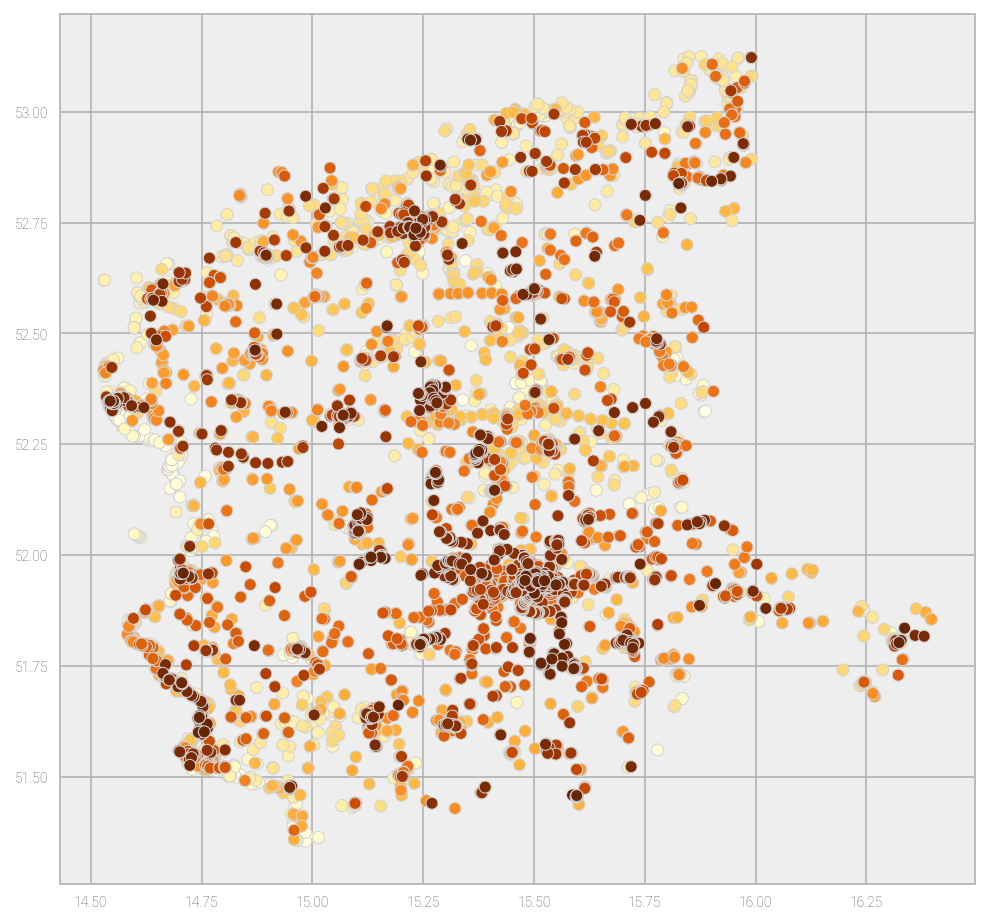

In [66]:
gdf.plot(
    figsize=(10, 8),
    legend=True,
    cmap='YlOrBr',
    scheme='quantiles',
    edgecolor='lightgray'
)